# Pairing Hamiltonianの量子計算 (pytket)



pytketを使った量子計算について述べる

Quantinuumによる[pytket user guide](https://docs.quantinuum.com/tket/user-guide/index.html)が役に立つ。

大きな注意点としては、大変ややこしいことに、回転ゲートの角度パラメータが$\pi/2$単位で与えられることである。

In [171]:
#必要に応じて...
#!pip install pytket
#!pip install pytket-qiskit
#!pip install pytket-projectq
#!pip install openfermion
#!pip install seaborn

import numpy as np
import itertools
from itertools import combinations
import seaborn as sns
cols = sns.color_palette("deep")
import matplotlib.pyplot as plt
import pandas as pd
from openfermion import QubitOperator
from pytket.circuit import Circuit, Qubit, Bit
from pytket.circuit.display import render_circuit_jupyter as draw
from pytket.utils import gate_counts
from pytket.utils import probs_from_state
from pytket.utils.expectations import get_operator_expectation_value
from pytket.extensions.qiskit import AerStateBackend
from pytket.extensions.qiskit import AerBackend


Hamiltonianなどを再び書き写しておいて...

In [172]:
class PairingHamiltonian:
    def __init__(self, Norb, Nocc, gval, delta_eps=1.0):
        self.Norb = Norb
        self.Nocc = Nocc
        self.delta_eps = delta_eps
        self.gval = gval
        self.basis = self.make_basis()
        self.epsilon = self.eval_epsilon()
        self.Hmat = self.eval_Hmat()

    def make_basis(self):
        self.basis = []
        for occ in combinations(range(self.Norb), self.Nocc):
            self.basis.append(occ)

        return self.basis
    
    def eval_epsilon(self):
        self.epsilon = [ 2 * i * self.delta_eps for i in range(self.Norb) ]
        return self.epsilon
    
    def eval_Hmat(self):
        dim = len(self.basis)
        self.Hmat = np.zeros((dim, dim))
        for bra_idx, bra in enumerate(self.basis):
            for ket_idx, ket in enumerate(self.basis):
                # Hamming distance
                diff = [ i for i in bra if i not in ket ]
                same = [ i for i in bra if i in ket ]
                # for SPE term
                if bra_idx == ket_idx:
                    self.Hmat[bra_idx, ket_idx] += np.sum( [self.epsilon[i] for i in same])
                    self.Hmat[bra_idx, ket_idx] += - self.gval * len(same) 
                # for pairing term
                if len(diff) == 1:
                    self.Hmat[bra_idx, ket_idx] = - self.gval

        return self.Hmat

def tuple_to_bitstring(tup, Norb, rev=True):
    bitint = 0
    for i in tup:
        bitint += 2**i
    if rev:
        bitstring = "|"+format(bitint, f'0{Norb}b')[::-1]+">"
    else:
        bitstring = "|"+format(bitint, f'0{Norb}b')+">"        
    return bitstring

Norb = 4
Nocc = 2
gval = 0.33  

Hamil = PairingHamiltonian(Norb, Nocc, gval)
evals, evecs = np.linalg.eigh(Hamil.Hmat)
evals = np.linalg.eigvalsh(Hamil.Hmat)
Egs_exact = evals[0]
E_HF = Hamil.Hmat[0,0]

print("basis:", Hamil.basis)
print([tuple_to_bitstring(tup, Norb) for tup in Hamil.basis])
print("eps: ", Hamil.epsilon)
print("Hmat: ", Hamil.Hmat)
print("evals: ", evals)
print("Egs_exact: ", Egs_exact, " E_HF", E_HF)
print("gs evec", evecs[:,0])
print("gs prob", evecs[:,0]**2)

params_exact = 0.5* np.array(
    [-0.48104276, -1.03976498, -0.98963981, -1.18481738, -0.54832984]
) 
# pytketの回転ゲートはpi/2単位で指定するので、pi/2で割っておく
params_exact = params_exact #

basis: [(0, 1), (0, 2), (0, 3), (1, 2), (1, 3), (2, 3)]
['|1100>', '|1010>', '|1001>', '|0110>', '|0101>', '|0011>']
eps:  [0.0, 2.0, 4.0, 6.0]
Hmat:  [[ 1.34 -0.33 -0.33 -0.33 -0.33  0.  ]
 [-0.33  3.34 -0.33 -0.33  0.   -0.33]
 [-0.33 -0.33  5.34  0.   -0.33 -0.33]
 [-0.33 -0.33  0.    5.34 -0.33 -0.33]
 [-0.33  0.   -0.33 -0.33  7.34 -0.33]
 [ 0.   -0.33 -0.33 -0.33 -0.33  9.34]]
evals:  [1.18985184 3.29649666 5.34       5.34       7.42853393 9.44511758]
Egs_exact:  1.1898518351360725  E_HF 1.3399999999999999
gs evec [0.97121327 0.18194077 0.09817385 0.09817385 0.06360816 0.01789242]
gs prob [9.43255208e-01 3.31024447e-02 9.63810492e-03 9.63810492e-03
 4.04599822e-03 3.20138762e-04]


## pytketでの回路作成

### Givens rotation

どうやらpytketにはGivens rotationの実装がなさそうなので自作しておく

In [173]:
def cG1(circ, c_qubit, i, j, theta):
    theta_4 = theta / 4 / (np.pi/2)
    circ.CX(i,j)
    circ.Ry(theta_4, i)
    circ.CX(j,i)
    circ.Ry(-theta_4, i)
    circ.CX(c_qubit, i)
    circ.Ry(theta_4, i)
    circ.CX(j,i)
    circ.Ry(-theta_4, i)
    circ.CX(c_qubit, i)
    circ.CX(i,j)

def G(circ, i, j, theta):
    theta_2 = theta / 2 / (np.pi/2)
    circ.CX(i,j)
    circ.Ry(theta_2, i)
    circ.CX(j,i)
    circ.Ry(-theta_2, i)
    circ.CX(j,i)
    circ.CX(i,j)  

$\pi/4$回転が正しいかチェック。角度が$\pi/2$単位である仕様に注意しつつ...

In [174]:
circ_G = Circuit(2)
circ_G.X(0)
G(circ_G, 0, 1, np.pi/4 / (np.pi/2))
draw(circ_G)

backend = AerStateBackend() 
transpiled = backend.get_compiled_circuit(circ_G, optimisation_level=2)
job = backend.process_circuit(transpiled) 
result = backend.get_result(job)
statevector_ftqc = result.get_state()
# 1e-10 未満の確率は表示しない  
probs_from_state(statevector_ftqc, min_p=1e-10) 


{(0, 1): 0.22984884706592998, (1, 0): 0.7701511529340701}

できた。

### Full-CI ansatz

では次に、軌道が4つ、占有数が2に対応する回路を考え、$g=0.33$の結果を再現する角度パラメータを指定してやると...

In [175]:
# Ansatz for Norb=4, Nocc=2
my_circ_1 = Circuit(Norb)

# HF
my_circ_1.X(0)
my_circ_1.X(1)
# HF + pair excitations expressed by G and cG1
G(my_circ_1, 1, 2, params_exact[0])
G(my_circ_1, 2, 3, params_exact[1])
cG1(my_circ_1, 2, 0, 1, params_exact[2])
cG1(my_circ_1, 3, 0, 1, params_exact[3])
cG1(my_circ_1, 3, 1, 2, params_exact[4])

draw(my_circ_1)
gate_counts(my_circ_1)

Counter({<OpType.CX: 45>: 26, <OpType.Ry: 35>: 16, <OpType.X: 23>: 2})

回路を保存することもできる:

```python
import pickle
with open("circuit_pytket.pkl","wb") as f:
    pickle.dump(my_circ_1,f)
```

では、状態作成したものを測定し確率を計算してみよう。statevectorを使うことにする。

In [176]:
circ = my_circ_1.copy()

# initialize backend with default settings
backend = AerStateBackend() 

# transpile and optimize for backend at level = 2 
# optimisation... British spelling なぜならQuantinuumはCambridge Quantumから来ているから。
circ_compiled = backend.get_compiled_circuit(circ, optimisation_level=2)  
gate_counts(circ_compiled)

job = backend.process_circuit(circ_compiled) 
result = backend.get_result(job)
statevector = result.get_state()
statevector[ np.abs(statevector) > 1e-10 ] 

array([0.01788929-8.66020112e-17j, 0.06360699-2.88837067e-16j,
       0.09817351-4.82563346e-16j, 0.09817219-3.94005123e-16j,
       0.18193913-7.09880803e-16j, 0.97121391-5.57798065e-15j])

In [177]:
probs_from_state(statevector, min_p=1e-10) # 1e-10 未満の確率は表示しない  

{(0, 0, 1, 1): 0.00032002678223212646,
 (0, 1, 0, 1): 0.004045849260479198,
 (0, 1, 1, 0): 0.009638037703111972,
 (1, 0, 0, 1): 0.00963777971356642,
 (1, 0, 1, 0): 0.03310184865198989,
 (1, 1, 0, 0): 0.9432564578886204}

厳密解における各状態の確率を再現できた。


## pytketでの演算子表現

pytketでもHamiltonianの表現方法は幾つかある。ひとつは`OpenFermion`の`QubitOperator`を用いる方法で...

In [178]:
# Qubit Hamiltonian
SPEs = Hamil.epsilon
obs = [ ]
coeffs = [ ]
H_qubit = QubitOperator()

## 1-Zp term
for i in range(Hamil.Norb):
    H_qubit += (  0.5 * (SPEs[i] - Hamil.gval) * (QubitOperator('') - QubitOperator('Z'+str(i)) ) ) 

## XX+YY term proportional to g (pairing strength)
for i in range(Hamil.Norb):
    for j in range(i+1, Hamil.Norb):
        if i == j:
            continue
        factor = - Hamil.gval / 2 
        XX = QubitOperator('X'+str(i)+' X'+str(j), factor)
        YY = QubitOperator('Y'+str(i)+' Y'+str(j), factor)
        H_qubit += XX 
        H_qubit += YY

print("H_qubit: ", H_qubit)

H_qubit:  5.34 [] +
-0.165 [X0 X1] +
-0.165 [X0 X2] +
-0.165 [X0 X3] +
-0.165 [Y0 Y1] +
-0.165 [Y0 Y2] +
-0.165 [Y0 Y3] +
0.165 [Z0] +
-0.165 [X1 X2] +
-0.165 [X1 X3] +
-0.165 [Y1 Y2] +
-0.165 [Y1 Y3] +
-0.835 [Z1] +
-0.165 [X2 X3] +
-0.165 [Y2 Y3] +
-1.835 [Z2] +
-2.835 [Z3]


Documentの[Expectation values](https://docs.quantinuum.com/tket/user-guide/examples/algorithms_and_protocols/expectation_value_example.html)を参考にしつつ、pytketの`QubitPauliOperator`に変換してみよう。

In [179]:
from pytket.pauli import Pauli, QubitPauliString
from pytket.utils.operators import QubitPauliOperator
pauli_sym = {"I": Pauli.I, "X": Pauli.X, "Y": Pauli.Y, "Z": Pauli.Z}

def qps_from_openfermion(paulis):
    """Convert OpenFermion tensor of Paulis to pytket QubitPauliString."""
    qlist = []
    plist = []
    for q, p in paulis:
        qlist.append(Qubit(q))
        plist.append(pauli_sym[p])
    return QubitPauliString(qlist, plist)

def qpo_from_openfermion(openf_op):
    """Convert OpenFermion QubitOperator to pytket QubitPauliOperator."""
    tk_op = dict()
    for term, coeff in openf_op.terms.items():
        string = qps_from_openfermion(term)
        tk_op[string] = coeff
    return QubitPauliOperator(tk_op)

hamiltonian_op = qpo_from_openfermion(H_qubit)
hamiltonian_op

{(): 5.34000000000000, (Zq[0]): 0.165000000000000, (Zq[1]): -0.835000000000000, (Zq[2]): -1.83500000000000, (Zq[3]): -2.83500000000000, (Xq[0], Xq[1]): -0.165000000000000, (Yq[0], Yq[1]): -0.165000000000000, (Xq[0], Xq[2]): -0.165000000000000, (Yq[0], Yq[2]): -0.165000000000000, (Xq[0], Xq[3]): -0.165000000000000, (Yq[0], Yq[3]): -0.165000000000000, (Xq[1], Xq[2]): -0.165000000000000, (Yq[1], Yq[2]): -0.165000000000000, (Xq[1], Xq[3]): -0.165000000000000, (Yq[1], Yq[3]): -0.165000000000000, (Xq[2], Xq[3]): -0.165000000000000, (Yq[2], Yq[3]): -0.165000000000000}

### エネルギーの測定

作ったansatzとHamiltonian operatorを、指定したバックエンドに投げて
`pytket.utils.expectations`に用意された`get_operator_expectation_value`関数で期待値を測定してみよう。

以下ではQiskit AerのStatevecvtor simulatorを用いる。

In [180]:
ansatz = my_circ_1.copy()
backend = AerStateBackend()
E_ftqc = get_operator_expectation_value(ansatz, hamiltonian_op, backend=backend)
print("E_ftqc: ", E_ftqc, "Egs_exact: ", Egs_exact, "E_HF: ", E_HF)

E_ftqc:  1.1898518352304368 Egs_exact:  1.1898518351360725 E_HF:  1.3399999999999999


## 回路パラメータの最適化

pytketを使ったVQE計算(回路の最適化)も試してみよう。

(勾配降下やAdamなどの最適化手法を使った方法がすぐにはわからなかったので)Nakanishi-Fujii-Todo法を実装して、逐次最適化してみよう。
参考: [Phys. Rev. Research 2, 043158 (2020)](https://doi.org/10.1103/PhysRevResearch.2.043158)

ざっと要点だけ説明すると、gradient freeなsequential optimizationの方法の一つ。

N個のパラメータに依存する１個の量子ゲートのパラメータに着目し、その値を最適化したいとき、
パラメータの周期を取り尽くす等間隔な2N+1点でエネルギーを測ると、エネルギーは周期関数になる。
その結果を離散フーリエ変換して、最小のエネルギーを求める点を推定し、これを各ゲートに対して収束するまで繰り返していく。

いま上の例で最適化したい回路はGivens rotationやcontrolled Givens rotationである。
上の自作関数を見てもわかるように、それぞれパラメータが符号も含めてそれぞれ2(4)個ある。
したがって、`G`(`cG`)の角度パラメータの最適化には5(9)点での計測が必要になる。

また、`G`や`cG`という量子ゲートを構成するすべての回転ゲートが周期を取り尽くすように測る必要があるため、
`G`(`cG`)の場合は関数の外から与える角度としては、$4\pi(8\pi)$周期分をカバーして測る必要がある。

initial params [3.44829694 4.49366732 3.78727399 3.42360201 2.66190161]
Optimizing parameters...
iteration     0 which_Gate 1 type G
Emeasured [1.4867657  1.79578918 1.63703289 1.47242273 1.89645555]


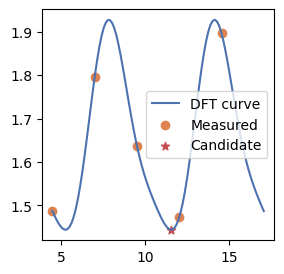

which_Gate 3 type cG1
Emeasured [1.44368379 1.83839806 1.5908143  1.79839549 1.8343694  1.6956903
 1.95097955 1.52029136 1.90655423]


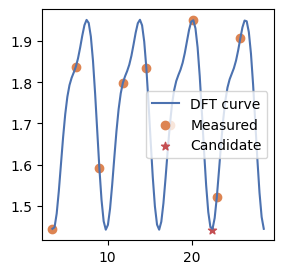

which_Gate 4 type cG1
Emeasured [1.44136355 1.57353789 1.47975579 1.54559194 1.53066566 1.49414067
 1.56461717 1.4473691  1.57767619]


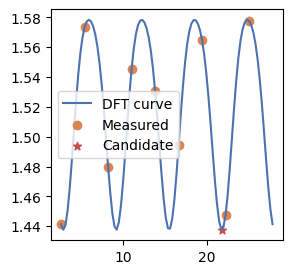

which_Gate 0 type G
Emeasured [1.43759698 1.93377273 4.07509191 4.9023242  3.27226269]


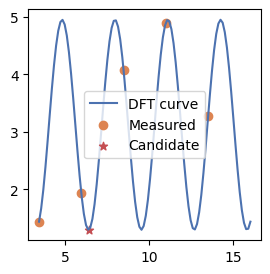

which_Gate 2 type cG1
Emeasured [1.29668783 1.33180213 1.25911905 1.35624767 1.24748919 1.36080235
 1.26475917 1.33840335 1.29777327]


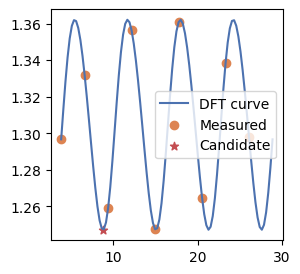

Energy_opt    1.2472132040
iteration     1 Energy_opt    1.1951439683
iteration     2 Energy_opt    1.1900667982
iteration     3 Energy_opt    1.1898545248
iteration     4 Energy_opt    1.1898518786
iteration     5 Energy_opt    1.1898518360
iteration     6 Energy_opt    1.1898518352
iteration     7 Energy_opt    1.1898518351
iteration     8 Energy_opt    1.1898518351
iteration     9 Energy_opt    1.1898518351
******************
E_initial 1.4867657043426625  最適化 => 1.1898518351361973 Egs_exact 1.1898518351360725 diff. 1.247890679678676e-13
******************


In [182]:
from scipy.optimize import minimize_scalar

def ansatz(params):
    circ = Circuit(4)
    circ.X(0)
    circ.X(1)
    G(circ, 1, 2, params[0])
    G(circ, 2, 3, params[1])
    cG1(circ, 2, 0, 1, params[2])
    cG1(circ, 3, 0, 1, params[3])
    cG1(circ, 3, 1, 2, params[4])
    return circ

def objective(params):
    circ = ansatz(params)
    return (
        get_operator_expectation_value(circ, hamiltonian_op, backend)
    )

def draw_DFT_curve(xplot, DFTcurve, spot, Es, x_min, y_min):
    fig = plt.figure(figsize=(3,3))
    ax = fig.add_subplot(1,1,1)
    ax.plot(xplot, DFTcurve, label="DFT curve", color=cols[0])
    ax.scatter(spot, Es, marker="o", label="Measured", color=cols[1])
    ax.scatter(x_min, y_min, marker="*", color=cols[3], label="Candidate")
    ax.legend()
    plt.show()
    plt.close() 

def eval_DFT_coeff(Es, spot):
    N = len(Es)    
    DFT_coef = np.zeros(N, dtype=float)

    for idx_M in range(N):
        t_data = Es[idx_M]
        for idx_coeff in range(N):
            #print("idx_M", idx_M, "idx_coeff", idx_coeff)
            if idx_coeff == N-1:
                DFT_coef[idx_coeff] += t_data
                #print("sum of Es??", DFT_coef[idx_coeff], "idx_M", idx_M, "t_data", t_data)
                continue
            theta_order = idx_coeff // 2 + 1
            if idx_coeff % 2 == 0:
                DFT_coef[idx_coeff] += 2 * t_data * np.cos(theta_order * spot[idx_M])
            else:
                DFT_coef[idx_coeff] += 2 * t_data * np.sin(theta_order * spot[idx_M])
    DFT_coef /= N
    if abs(np.mean(Es) - DFT_coef[-1]) > 1e-10:
        print("Something wrong in DFT")
        exit()
    return DFT_coef

def func_DFT_coeff(DFT_coef):
    def DFTcurve(x):
        y = 0
        for n in range(len(DFT_coef)):
            if n == len(DFT_coef) - 1:
                y += DFT_coef[n]
                break
            theta_order = n // 2  + 1
            if n % 2 == 0:
                y += DFT_coef[n] * np.cos( theta_order * x)
            else:
                y += DFT_coef[n] * np.sin( theta_order * x)
        return y
    return DFTcurve

def DFT(it, Es, spot, verbose, method="scipy"):
    N_duration = (len(Es) - 1) // 2
    DFT_coef = eval_DFT_coeff(Es, spot)
    theta_current = spot[0] 
    xplot    = np.linspace(theta_current, theta_current + N_duration *  2*np.pi, 100)
    DFTcurve = func_DFT_coeff(DFT_coef)(xplot)
    if method == "scipy":
        obj = minimize_scalar(func_DFT_coeff(DFT_coef), bounds=(theta_current, theta_current + 2 * np.pi * N_duration))
        x_min = obj.x 
        y_min = obj.fun
    elif method == "naive":
        idx_min = np.argmin(DFTcurve)
        x_min = xplot[idx_min]
        y_min = DFTcurve[idx_min]

    if verbose and it % 10 == 0:
        draw_DFT_curve(xplot, DFTcurve, spot, Es, x_min, y_min)
    new_theta = x_min % (2 * np.pi * N_duration)
    return new_theta

def NFTmethod(it, Ecurrent, params, which_Gate, verbose):
    params_ = params.copy()
    # Making point to measure for Discrete Fourier Transformation
    # GやcG1で使われる角度は中で2(4)で割って使われる。これらが0から2piの範囲をカバーしなければならないことに注意してfactorをかけている。
    if where_is_G_or_cG1[which_Gate] == "G":
        spot = [params_[which_Gate]] + [ params_[which_Gate] + n * 2 * (2 * np.pi)/5 for n in range(1,5) ]
        spot = np.array(spot) 
    elif where_is_G_or_cG1[which_Gate] == "cG1":
        spot = [params_[which_Gate]] + [ params_[which_Gate] + n * 4 * (2 * np.pi)/9 for n in range(1,9) ]
        spot = np.array(spot) 
    else:
        print("Something wrong")
    if verbose:
        spot_in_2pi = spot.copy()
        spot_in_2pi -= spot[0]
        spot_in_2pi = spot_in_2pi / (2 * np.pi)
        print("which_Gate", which_Gate, "type", where_is_G_or_cG1[which_Gate])
    
    # Measure the energy at the spot
    tmp = params_.copy()
    Es = np.zeros(len(spot))
    Es[0] = Ecurrent
    for idx in range(1, len(spot)): # 0 is already measured
        tmp[which_Gate] = spot[idx]
        E = objective(tmp)
        Es[idx] = E
    if verbose:
        print("Emeasured", Es)

    param_best = DFT(it, Es, spot, verbose)
    # Find a minimum point
    params_[which_Gate] = param_best
    return params_

np.random.seed(0)
where_is_G_or_cG1 = {0: "G", 1: "G", 2: "cG1", 3: "cG1", 4: "cG1"}
params = np.random.rand(5) * np.pi * 2 
print("initial params", params)
E_initial = E_current = objective(params)

it_max = 100
verbose = True
stag = 0
print("Optimizing parameters...")
for it in range(it_max):
    print("iteration %5d " % it, end="")
    if it > 0:
        verbose = False
    E_prev = E_current
    for which_Gate in np.random.choice(5, 5, replace=False):   
        params_ = NFTmethod(it, E_current, params, which_Gate, verbose)
        E_new = objective(params_)
        params = params_.copy()
        E_current = E_new

    print("Energy_opt %15.10f" % E_current)
    if abs(E_current - E_prev) < 1e-8:
        stag += 1
    if stag > 3:
        break

print("******************")
print("E_initial", E_initial, " 最適化 =>", E_current, "Egs_exact", Egs_exact, "diff.", E_current - Egs_exact)
print("******************")


上の場合は、 statevectorを用いたので数回~10回程度で最適化が終了する、
実際には、simulatorの場合でもshotで測る場合はshotノイズ、実機の場合はその他様々なノイズの影響を受けるが、
いずれにしても、回路の測定が高速にできればとても強力な最適化手法の一つである。